## mPyPl

### Tutorial for using Monadic Python Pipeline Library

Available as **http://bit.do/mpypldemo**

mPyPl is a library that will dramatically simplify data manipulation tasks, especially for those familiar with functional programming techniques. In addition to using clean pipeline syntax, it will also allow you to operate on complex data processing pipelines with multiple streams of data, and do all that in memory-efficient way due to lazy evaluation.

Original library and documentation is available on GitHub: https://github.com/shwars/mPyPl

## 1. Installation

mPyPl is pip-installable, so the installation is very straightforward:

In [41]:
import sys
!{sys.executable} -m pip install mPyPl

To use `mPyPl` in your code, we suggest you do the following [standard imports](https://github.com/shwars/mPyPl/wiki/Standard-Imports):

In [ ]:
import mPyPl as mp
from pipe import *

## 2. Pipes

`mPyPl` relies heavily on pipeline syntax offered by [`pipe`](https://pypi.org/project/pipe/) library by Julien Pallard. Let's first understand how piping works.

Consider [Problem \#2](https://projecteuler.net/problem=2) from [Project Euler](https://projecteuler.net/): *By considering the terms in the Fibonacci sequence whose values do not exceed four million, find the sum of the even-valued terms*. 

Without pipelines, we can write the solution in the following way:

In [42]:
def fiblist(n):
    a,b = 1,1
    l = []
    while a<n:
        l.append(a)
        a,b = a+b,a
    return l
        
L1 = fiblist(4000000)
L2 = filter(lambda x:x%2==0,L1)
sum(L2)

4613732

Or we can write it in a long statement like this:

In [43]:
sum(filter(lambda x:x%2==0,fiblist(4000000)))

4613732

With pipes, we can operate on **infinite sequences**, and also decompose operations even further, making code more clear and modular.

First, let's define fibonacci number generator:

In [44]:
def fib():
    a,b = 1,1
    while True:
        yield a
        a,b = a+b,a

We can then use it as a source for pipelines, for example:

In [45]:
fib() | take(10) | as_list

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89]

First Fibonacci number above 4000000:

In [46]:
fib() | where(lambda x:x>4000000) | first

5702887

And the original problem:

In [47]:
fib() | take_while(lambda x:x<4000000) | where(lambda x:x%2==0) | add

4613732

Note, that pipelines are **lazily evaluated**, i.e. all values of the pipeline are not stored in memory, but are computed on the fly when they are required by the terminating function. This allows using potentially **infinite sequences**, like `fib` in our example. 

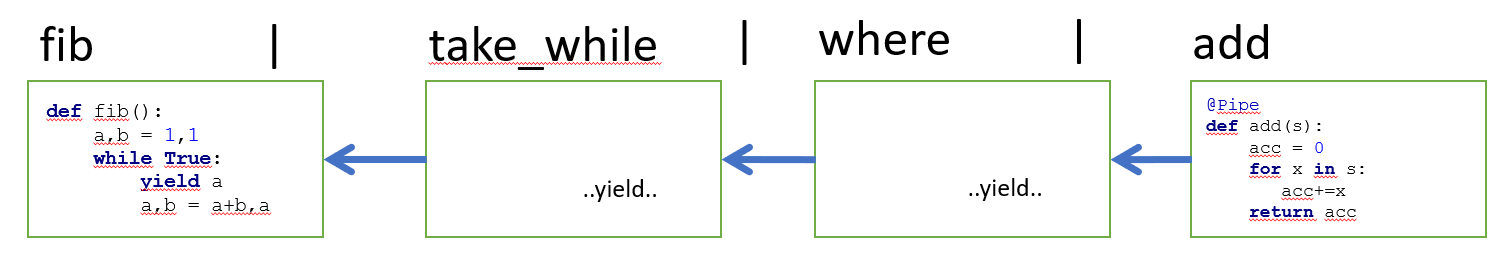

## 3. mPyPl basics

`mPyPl` extends the notion of pipes with named pipelines, i.e. elements flowing through pipelines are named dictionaries called `mdict`'s. They are very similar to traditional dictionaries, but support lazy field evaluation, on-demand field computation and so on.

This approach is very useful in machine learning, because we often need to enhance original data with some additional fields, for example adding square of some value, or computing image feature embeddings. Thus `mPyPl` is especially useful for data processing in AI/ML.

Consider the following problem: *find the first Fibonacci number, whose square is above 4000000*. To solve it, we first convert the original `fib` sequence into `mPyPl` sequence of `mdict`'s with a field `x`, then add a field for $x^2$, filter and get the result:

<img src="https://habrastorage.org/webt/zl/mq/zd/zlmqzdastsudpojo-grrmrnqogs.jpeg" width="60%" />

In [ ]:
fib() | mp.as_field('x') | mp.apply('x','xsq',lambda x:x*x) | mp.filter('xsq',lambda x:x>4000000) | mp.select_field('x') | first

It is traditional and very convenient to start long pipelines with `(`, so that we can write them in multiline way:

In [48]:
(fib() 
 | mp.as_field('x') 
 | mp.apply('x','xsq',lambda x:x*x) 
 | mp.filter('xsq',lambda x:x>4000000) 
 | mp.select_field('x') 
 | first
)

2584

## 4. Anatomy of `apply`

`apply` is the most widely used operation in `mPyPl`. It takes values from one or more fields, and computes a new field based on their values. It has two variations:
* `apply('<field>','<new_field>',lambda x: ...x...)` - one input field
* `apply(['<field0>',...,'<field_n>'],'<new_field>',lambda x: ...x[0]...x[n].)` - several input fields

**Example**: Take a few images from a given directory and print them together with their resolution overlayed on top.

To obtain the list of files in a given directory, we use `get_files` (before we download some pictures to play with using `wget`):

In [ ]:
for x in ['Girl_and_cat','doggie','kitten']:
    !wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/{x}.jpg

In [49]:
mp.get_files('.',ext=".jpg") | as_list

['./doggie.jpg', './Girl_and_cat.jpg', './kitten.jpg']

Now we download actual images together with files using OpenCV, and display them using special utility function for showing images, also available in `mPyPl`:

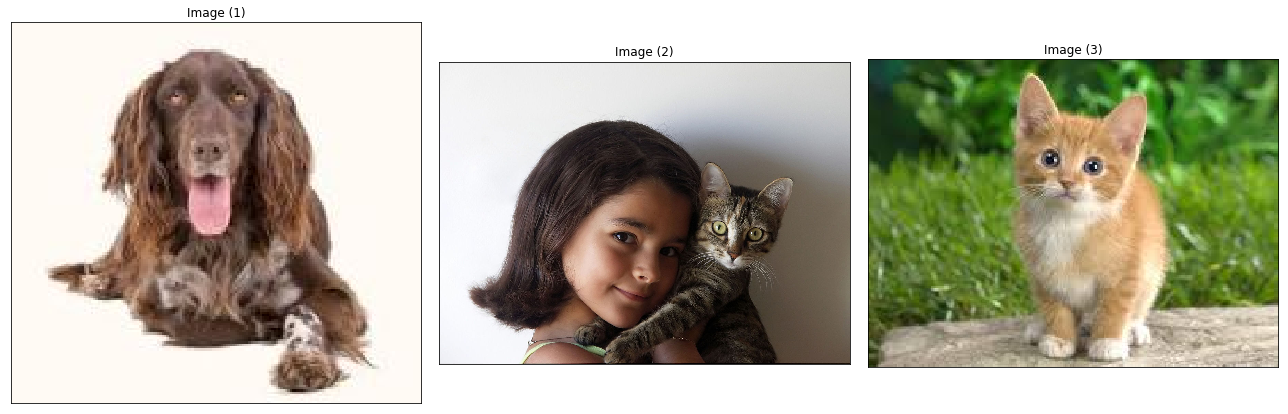

In [50]:
import cv2
import mPyPl.utils.image as mpui

(mp.get_files('.',ext=".jpg") 
 | mp.as_field('fname')
 | mp.apply('fname','img',lambda x:cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
 | mp.select_field('img')
 | mp.pexec(mpui.show_images)
)

Here we have used another useful namespace, `mPyPl.utils.image`. The function `pexec` executes specified function on the list of objects obtained from the pipeline.

To overlay image size and filename over the image, we need to pass both filename and image to the lambda function. Thus we use the second form of apply. Also, because `cv2.putText` changes the original image, we do not need an output field name in `apply`:

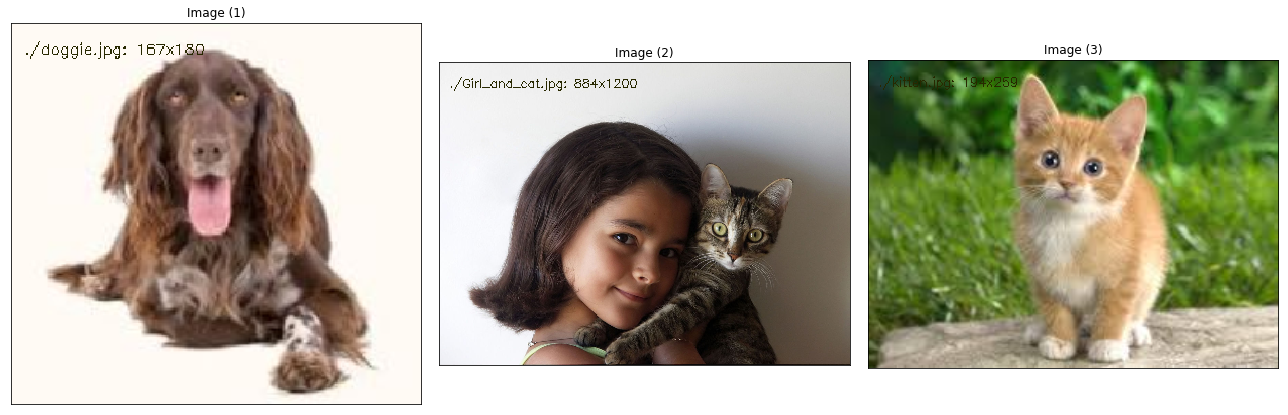

In [51]:
(mp.get_files('.',ext=".jpg") 
 | mp.as_field('fname')
 | mp.apply('fname','img',lambda x:cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB))
 | mp.apply('img','size',lambda x:"{}x{}".format(x.shape[0],x.shape[1]))
 | mp.sapply('img',lambda x:mpui.im_resize(x,(None,300)))
 | mp.apply(['fname','img','size'],None,
            lambda x: cv2.putText(x[1],x[0]+": "+x[2], (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (40,40,0)))
 | mp.select_field('img')
 | mp.pexec(mpui.show_images)
)

Important things here:
 * We use convenient `im_resize` function from `mPyPl` image utils that allows us to keep proportions and specify just one dimension of the image
 * When we resize the image, we can place it into the same field to avoid confusion and save memory. This can be done specifying the same input and output name for `apply`, or using `sapply` (self-apply).

## 5. `mPyPl` for Classification

Many data science tasks are classification - thus provide special support for those tasks. Very powerful function to do that is `get_datastream`. 

It assumes all files are stored in different directories, one per class, under some base directory `base_dir`, and retrieves a data stream will all files below `base_dir`, providing its class, class id and filename. What `get_datastream` can do:

* automatically figure out class names and their numeric ids based on directory structure
* automatically split files between train/test and train/validaton/test datasets, and store this split into text file for repeated experments

## 6. Other typical tasks

Here are some other tasks we have used `mPyPl` for:

* [Working with Pascal VOC annotations](https://github.com/shwars/mPyPl/wiki/Reading-PASCAL-VOC-Format), for example [training Custom Vision on data in Pascal VOC format](https://github.com/shwars/NeuroWorkshop/blob/master/Notebooks/ObjectDetection-CustVision.ipynb).
* Rendering video frame-by-frame and superimposing some data/model results on top of video. 
* A very complex example of using `mPyPl` for collision detection in car racing can be found [here](https://github.com/vJenny/race-events-recognition).

## 7. More documentation

Some examples of using `mPyPl` for typical tasks can be found on the [project wiki](https://github.com/shwars/mPyPl/wiki). For example, you can check out [cats vs. dogs Keras classical example](https://github.com/shwars/mPyPl/wiki/Transfer-learning-with-Keras-on-Cats-Dogs-Dataset).